In [1]:
import torch
import math
import torch_geometric
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from tqdm import tqdm
import matplotlib.pyplot as plt
import copy
from os.path import join
from rdkit import Chem
from rdkit.Chem import ChemicalFeatures, AllChem
from rdkit import RDConfig
from rdkit.Chem.rdmolfiles import MolFromMolFile
import numpy as np
import pandas as pd
import ast
from sklearn.cluster import AgglomerativeClustering
import random
import torch
import deepdish as dd
import torch.nn.functional as F
from torch.nn import Sequential, Linear, ReLU, GRU, BatchNorm1d, Dropout
import torch_geometric.transforms as T
from torch_geometric.nn import NNConv, Set2Set, GCNConv, global_add_pool, global_mean_pool,GATConv,GINConv
from torch.nn import Sequential, Linear, ReLU
from torch_geometric.data import DataLoader
from torch_geometric.utils import remove_self_loops
from torch_geometric.data import Data
from torch_geometric.data import InMemoryDataset #easily fits into cpu memory
from torch.utils.data import Subset
import pickle
import CS224W_final_project.model as dynaformer_model

In [2]:
def add_edges_list(root, code):
    ligand_filename = code + "_h.sdf"
#     print(join(root, code, ligand_filename))
    m = MolFromMolFile(join(root, code, ligand_filename))
    atoms1 = [b.GetBeginAtomIdx() for b in m.GetBonds()]
    atoms2 = [b.GetEndAtomIdx() for b in m.GetBonds()]    
    # Edge attributes: distance; SINGLE; DOUBLE; TRIPLE; AROMATIC.
    edge_weights= []
    coords = m.GetConformers()[0].GetPositions()  # Get a const reference to the vector of atom positions
    for b in m.GetBonds():
        if str(b.GetBondType()) == "SINGLE":
            edge_weights.append(1)
        elif str(b.GetBondType()) == "DOUBLE":
            edge_weights.append(2)
        elif str(b.GetBondType()) == "TRIPLE":
            edge_weights.append(3)
        else:
            edge_weights.append(4)
    edge_features = np.array(edge_weights) 
    # since the torch-geometric graphs are directed add reverse direction of edges
    return np.array([atoms1 + atoms2, atoms2 + atoms1]), np.concatenate((edge_features, edge_features), 0)

In [3]:
class PDBbindDataset(InMemoryDataset):
    def __init__(self, root, node_features,activity_csv,transform=None, pre_transform=None):
        self.root = root
        self.node_features = node_features
        self.activity_csv = activity_csv
        super(PDBbindDataset, self).__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        return []

    @property
    def processed_file_names(self):
        return ["data.pt"]

    def download(self):
        pass

    def process(self):

        self.node_data = dd.io.load(join(self.root, self.node_features))
#         print(self.node_data.keys())
        # load csv with activity data and simlarity scores
        self.activity = pd.read_csv(join(self.root, self.activity_csv))
        # create lists of edges and edge descriptors 
        self.edge_indexes = {key: add_edges_list(self.root, key)[0] for key in self.activity.PDB }
        self.edge_data = {key: add_edges_list(self.root, key)[1] for key in self.activity.PDB }
        
        # Read data into huge `Data` list.
        data_list = [Data(x = torch.FloatTensor(self.node_data[key]),
                          edge_index = torch.LongTensor(self.edge_indexes[key]),
                          edge_attr = torch.FloatTensor(self.edge_data[key]),
                          y = torch.FloatTensor([self.activity[self.activity.PDB == key].pk.iloc[0]])) for key in self.activity.PDB ]
      
        if self.pre_filter is not None:
            data_list = [data for data in data_list if self.pre_filter(data)]

        if self.pre_transform is not None:
            data_list = [self.pre_transform(data) for data in data_list]
        
        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_paths[0])

In [13]:
dataset = PDBbindDataset("refined-set/coreset2016/", 
                         "refined-set/coreset2016/coreset.h5",
                         "refined-set/coreset2016/coreset.csv")

/var/folders/7m/ygy153sx5_x17rklnslfqxdw0000gn/T/ipykernel_8114/361809795.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.data, self.slices = torch.load(self.proces

In [21]:
def pyg_to_networkx(data):
    G = nx.Graph()  # Create an empty NetworkX graph

    # Add nodes to the NetworkX graph
    for i in range(data.x.size(1)):  # Loop over each node
        G.add_node(i, feature=data.x.T[i].numpy())  # Add node with its features (if any)

    # Add edges to the NetworkX graph
    edge_list = data.edge_index.numpy()  # Convert edge_index to numpy
    for i in range(edge_list.shape[1]):
        G.add_edge(edge_list[0, i], edge_list[1, i])  # Add edge between nodes

    return G

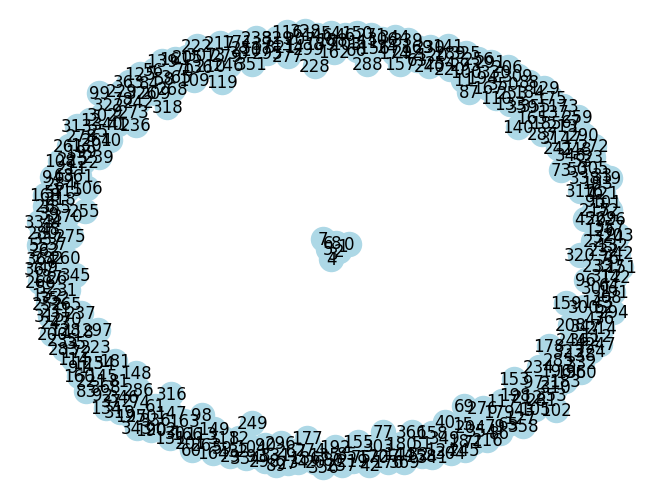

In [22]:
import networkx as nx
pos = nx.spring_layout(pyg_to_networkx(dataset[0]))  # Compute the layout for visualization
nx.draw(pyg_to_networkx(dataset[0]), pos, with_labels=True, node_color='lightblue', font_size=12)
plt.show()

In [5]:
with open('CS224W_final_project/refined-set-2020-5-5-5_test.pkl', 'rb') as f:
  dataset = pickle.load(f)

for i in range(len(dataset)):
  dataset[i] = Data(**dataset[i].__dict__)  # allowing to use different pyg version

In [6]:
graph_model = dynaformer_model.Graphormer(
    num_layers=2,
    input_node_dim=dataset[0].num_node_features,
    node_dim=32,
    input_edge_dim=dataset[0].num_edge_features,
    edge_dim=8,
    output_dim=1,
    n_heads=32,
    ff_dim=32,
    max_in_degree=4,
    max_out_degree=4,
    max_path_distance=4,
    num_heads_spatial=2
)

In [7]:
class Net(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(Net, self).__init__()
        #GCN-representation
        self.input_dim = input_dim
        self.hidden_dim_middle = 2 * hidden_dim
        self.hidden_dim = hidden_dim
        self.hidden_dim_end = int(hidden_dim / 2)
        
        self.conv1 = GCNConv(self.input_dim, self.hidden_dim_middle, cached=False )
        self.bn01 = BatchNorm1d(self.hidden_dim_middle)
        self.conv2 = GCNConv(self.hidden_dim_middle, self.hidden_dim, cached=False )
        self.bn02 = BatchNorm1d(self.hidden_dim)
        self.conv3 = GCNConv(self.hidden_dim, self.hidden_dim, cached=False)
        self.bn03 = BatchNorm1d(self.hidden_dim)
        #GAT-representation
        self.gat1 = GATConv(self.input_dim, self.hidden_dim_middle,heads=3)
        self.bn11 = BatchNorm1d(self.hidden_dim_middle*3)
        self.gat2 = GATConv(self.hidden_dim_middle*3, self.hidden_dim,heads=3)
        self.bn12 = BatchNorm1d(self.hidden_dim*3)
        self.gat3 = GATConv(self.hidden_dim*3, self.hidden_dim,heads=3)
        self.bn13 = BatchNorm1d(self.hidden_dim*3)
        #GIN-representation
        fc_gin1=Sequential(Linear(self.input_dim, self.hidden_dim_middle), ReLU(), Linear(self.hidden_dim_middle, self.hidden_dim_middle))
        self.gin1 = GINConv(fc_gin1)
        self.bn21 = BatchNorm1d(self.hidden_dim_middle)
        fc_gin2=Sequential(Linear(self.hidden_dim_middle, self.hidden_dim), ReLU(), Linear(self.hidden_dim, self.hidden_dim))
        self.gin2 = GINConv(fc_gin2)
        self.bn22 = BatchNorm1d(self.hidden_dim)
        fc_gin3=Sequential(Linear(self.hidden_dim, self.hidden_dim_end), ReLU(), Linear(self.hidden_dim_end, self.hidden_dim_end))
        self.gin3 = GINConv(fc_gin3)
        self.bn23 = BatchNorm1d(self.hidden_dim_end)
        #Fully connected layers for concatinating outputs
        self.fc1=Linear(self.hidden_dim*4 + self.hidden_dim_end, self.hidden_dim_middle)
        self.dropout1=Dropout(p=0.2,)
        self.fc2=Linear(self.hidden_dim_middle, self.hidden_dim_end)
        self.dropout2=Dropout(p=0.2,)
        self.fc3=Linear(self.hidden_dim_end, 1)
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        y=x
        z=x
        #GCN-representation
        x = F.relu(self.conv1(x, edge_index))
        x = self.bn01(x)
        x = F.relu(self.conv2(x, edge_index))
        x = self.bn02(x)
        x = F.relu(self.conv3(x, edge_index))
        x = self.bn03(x)
        x = global_add_pool(x, data.batch)
        #GAT-representation
        y = F.relu(self.gat1(y, edge_index))
        y = self.bn11(y)
        y = F.relu(self.gat2(y, edge_index))
        y = self.bn12(y)
        y = F.relu(self.gat3(y, edge_index))
        y = self.bn13(y)
        y = global_add_pool(y, data.batch)
        #GIN-representation
        z = F.relu(self.gin1(z, edge_index))
        z = self.bn21(z)
        z = F.relu(self.gin2(z, edge_index))
        z = self.bn22(z)
        z = F.relu(self.gin3(z, edge_index))
        z = self.bn23(z)
        z = global_add_pool(z, data.batch)
        #Concatinating_representations
        cr=torch.cat((x,y,z),1)
        cr = F.relu(self.fc1(cr))
        cr = self.dropout1(cr)
        cr = F.relu(self.fc2(cr))
        cr = self.dropout2(cr)
        cr = self.fc3(cr)
        cr = F.relu(cr).view(-1)
        return cr  

In [8]:
val_ids, train_ids = train_test_split([i for i in range(len(dataset))], test_size=0.5, random_state=42)
train_loader = DataLoader(Subset(dataset, train_ids), batch_size=4)
val_loader = DataLoader(Subset(dataset, val_ids), batch_size=4)

/Users/rbasto/miniconda3/envs/env224W/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
def train(model, train_loader,epoch,device,optimizer,scheduler):
    model.train()
    loss_all = 0
    error = 0
    
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        loss = F.mse_loss(model(data), data.y)
        loss.backward()
        loss_all += loss.item() * data.num_graphs
        error += (model(data) - data.y).abs().sum().item()  # MAE
        torch.nn.utils.clip_grad_value_(model.parameters(), 1)
        optimizer.step()
    return loss_all / len(train_loader.dataset), error / len(train_loader.dataset)


@torch.no_grad()
def test(model, loader,device):
    model.eval()
    error = 0

    for data in loader:
        data = data.to(device)
        error += (model(data) - data.y).abs().sum().item()  # MAE
    return error / len(loader.dataset)


@torch.no_grad()
def test_predictions(model, loader):
    model.eval()
    pred = []
    true = []
    for data in loader:
        data = data.to(device)
        pred += model(data).detach().cpu().numpy().tolist()
        true += data.y.detach().cpu().numpy().tolist()
    return pred, true

In [10]:
device = 'cpu'
best_val_error = None
best_model = None
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_errors, valid_errors,test_errors = [], [],[]
model = Net(dataset[0].num_node_features, 64).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
                                factor=0.95, patience=10,
                                min_lr=0.00001)
for epoch in range(1, 1001):
    lr = scheduler.optimizer.param_groups[0]['lr']
    loss, train_error = train(model, train_loader,epoch,device,optimizer,scheduler)
    val_error = test(model, val_loader,device)
    train_errors.append(train_error)
    valid_errors.append(val_error)

    if best_val_error is None or val_error <= best_val_error:
        best_val_error = val_error
        best_model = copy.deepcopy(model)

    print('Epoch: {:03d}, LR: {:.7f}, Loss: {:.7f}, Validation MAE: {:.7f}'
        .format(epoch, lr, loss, val_error))
print('leng of test errors = ', len(test_errors))

RuntimeError: Found dtype Long but expected Float

In [98]:
from sklearn.metrics import r2_score, mean_squared_error

coreset = PDBbindDataset("coreset2016", 
                         "coreset.h5",
                         "coreset2016.csv")
test_loader = DataLoader(coreset, batch_size=64, shuffle=False)
pred, true = test_predictions(model, test_loader)

plt.plot(pred, true, "r.")
plt.plot(np.unique(true), np.poly1d(np.polyfit(pred, true, 1))(np.unique(true)))
plt.text(9., 4., "RMSE = " + str(math.sqrt(mean_squared_error(true, pred)))[:5])
plt.text(9., 6., "R^2 = " + str(r2_score(true, pred))[:5])
plt.xlabel("predicted constants")
plt.ylabel("true constants")
plt.show()